# Examining Point Clouds

This notebook is for examining the point cloud data generated by the first analysis phase (phase 1). Plots of the individual traces point clouds in two and three dimensions can be made to check the status of the results. This is helpful for testing the parameters generated by the first phase. It actually runs a mini-version of phase 1. Note that the data generated here is NOT saved. This is only for testing.

### Imports

First we import all of the necessary code from the repository. Note the sys.path.append. This is used to pass the path to the repository to the interpreter. 

In [261]:
import sys
sys.path.append('..')
from spyral.core.config import load_config
from spyral.core.workspace import Workspace
from spyral.core.get_event import GetEvent, GET_DATA_TRACE_START, GET_DATA_TRACE_STOP
from spyral.core.point_cloud import PointCloud
from spyral.phase_1 import get_event_range
from spyral.correction import create_electron_corrector, generate_electron_correction
import h5py as h5
import matplotlib.pyplot as plt
import numpy.random as random
import numpy as np
from pathlib import Path

### Configuration

Now we'll load the configuration we want to use. Configurations are stored in JSON files using the conventions defined by the example file shipped with the repository (config.json). By default, this notebook reads the example file, but this can be changed. Additionally, once the config is loaded, you can always tweak the fields for rapid testing of different parameters.

We then hand off the workspace configuration to the Workspace class. The Workspace helps us handle paths to various files.

In [262]:
config = load_config('../local_config.json')
# Tweak some parameters
# config.trace.peak_threshold = 1

# Create our workspace
ws = Workspace(config.workspace)

### Data Loading

Now that our configuration is loaded, we can start reading and analyzing some data. Step one is to access the raw trace datafile. This means that you need to pick a run to analyze; we store the run number in a variable for later reference. To analyze a different run simply change the run number.

We then ask the workspace to retrieve the trace file path for our selected run number. We then use the h5py library to open the associated h5 file. 

In [263]:
run_number = config.run.run_min
trace_file = h5.File(ws.get_trace_file_path(run_number))

Our file is now loaded. Now we need to navigate to the correct group of the h5 structure. The traces are stored in the 'get' group.

In [264]:
trace_group: h5.Group = trace_file['get']

With a group loaded, we can now access the actual trace data! The default loading behavior is to select a random event (set of traces), since when testing you'll want to test your parameters on many different events. However, one can also fix the event by setting the event number to a constant value for debugging. Once the event number is chosen we then retrieve the raw trace data from the h5 file as a Dataset. Note that this operation can fail sometimes, if an event was omitted for some reason. If that happens just select a different event number.

In [265]:
# Ask the trace file for the range of events
min_event, max_event = get_event_range(trace_file)
# Select a random event
event_number = random.randint(min_event, max_event)
print(f'Event: {event_number}')
# Can always overwrite with hardcoded event number if needed
# event_number = 6847

event_data: h5.Dataset = trace_group[f'evt{event_number}_data']


Event: 6847


### Analyzing

Now that we've loaded our data, it's time to do some analysis! Step one is just to see what some traces look like, without any analysis at all. Again here, we're going to pick a random trace to look at, but you may want to pick a specific trace depending on your needs.

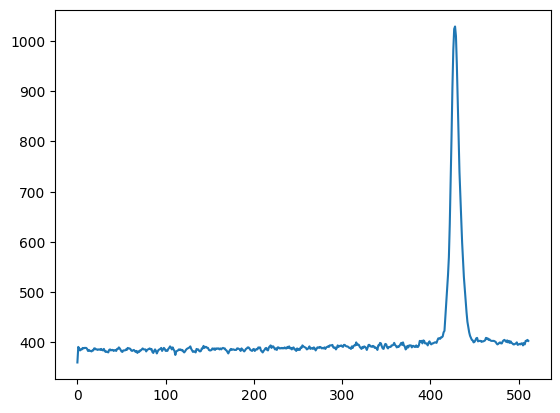

In [266]:
trace_number = random.randint(0, len(event_data))
raw_trace_data = event_data[trace_number]
time_bucket_range = np.arange(start=0, stop=512)
plt.plot(time_bucket_range, raw_trace_data[GET_DATA_TRACE_START:GET_DATA_TRACE_STOP])

Above you should see the plot of the raw trace! Now we can feed this trace data through the initial analysis by passing it along to the GetEvent class, along with the event number, and trace configuration parameters.

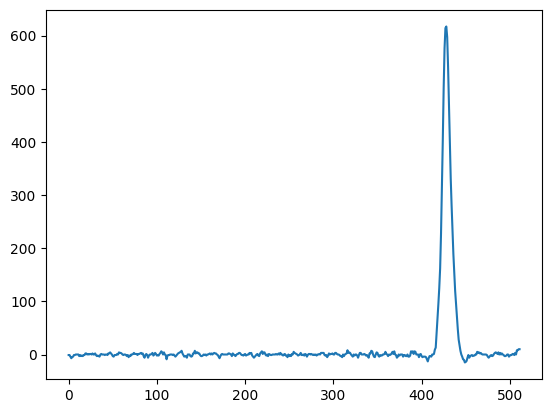

In [267]:
event = GetEvent(event_data, event_number, config.trace)
plt.cla()
plt.plot(time_bucket_range, event.traces[trace_number].raw_data)
plt.show()

You may see a pretty different trace on the other side of the initial analysis! The big thing that happened in that little code snippet was the removal of the trace baseline. This is done via a low-pass filter using a Fourier transform.

The next step is to run the peak finding analysis and generate a point cloud by retrieveing the positional data of each trace. This is done by passing our GetEvent to the PointCloud class, along with some additional data for connecting the electronics hardware address to the physical detector pad.

In [268]:
cloud = PointCloud()
correction_path = ws.get_correction_file_path(config.detector.efield_correction_name)
if not correction_path.exists():
    generate_electron_correction(Path(config.detector.garfield_file_path), correction_path, config.detector)
corrector = create_electron_corrector(correction_path)

cloud.load_cloud_from_get_event(event, ws.get_pad_map(), corrector)
cloud.calibrate_z_position(config.detector.micromegas_time_bucket, config.detector.window_time_bucket, config.detector.detector_length)

Now that our cloud is loaded, the first thing we'd want to check is the peak finding. To retrieve the z-position of each trace, the peak (centroid) of each trace must be found. We can examine this using the code snippet below.

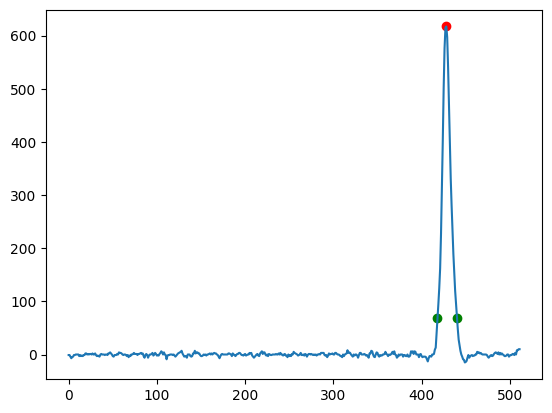

In [269]:
plt.plot(time_bucket_range, event.traces[trace_number].raw_data)
for peak in event.traces[trace_number].peaks:
    plt.scatter(peak.centroid, peak.amplitude, color='red')
    plt.scatter(peak.negative_inflection, event.traces[trace_number].raw_data[peak.negative_inflection], color='green')
    plt.scatter(peak.positive_inflection, event.traces[trace_number].raw_data[peak.positive_inflection], color='green')
plt.show()


You should see your trace plotted again, but this time with highlighted points corresponding to the centroid (red) and the peak edges (green). If you don't see anything, try tweaking some configuration parameters and re-running everything!

Now that we've looked at the peak finding, we can look at the actual point cloud itself! Below are several plots examining the geometry of the point cloud.

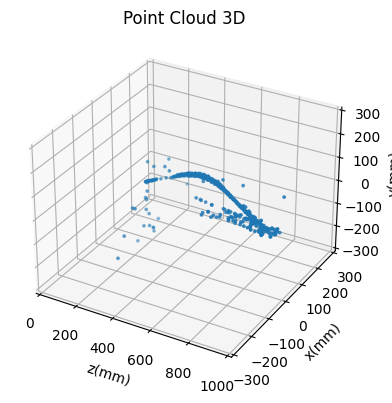

In [270]:

# Plot the 3-D point cloud
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(4)
ax = fig.add_subplot(projection='3d')
ax.scatter(cloud.cloud[:, 2], cloud.cloud[:, 0], cloud.cloud[:, 1], s=3)
ax.set_title('Point Cloud 3D')
ax.set_xlabel('z(mm)')
ax.set_xlim(0.0, 1000.0)
ax.set_ylabel('x(mm)')
ax.set_ylim(-300.0, 300.0)
ax.set_zlabel('y(mm)')
ax.set_zlim(-300.0, 300.0)
fig.tight_layout()
plt.show()

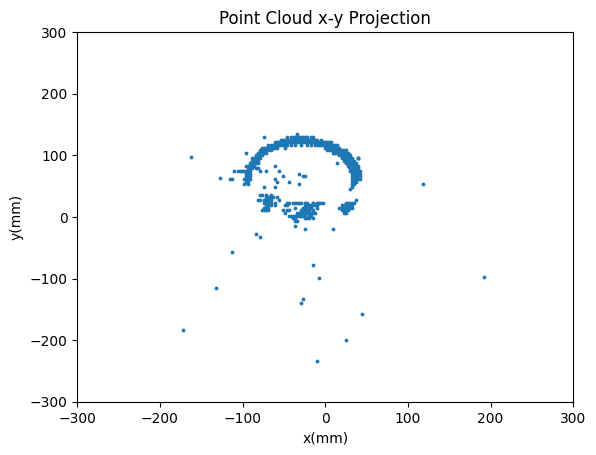

In [271]:
# Plot x-y  projection
plt.scatter(cloud.cloud[:, 0], cloud.cloud[:, 1], s=3)
plt.title('Point Cloud x-y Projection')
plt.xlabel('x(mm)')
plt.xlim(-300.0, 300.0)
plt.ylabel('y(mm)')
plt.ylim(-300.0, 300.0)
plt.show()

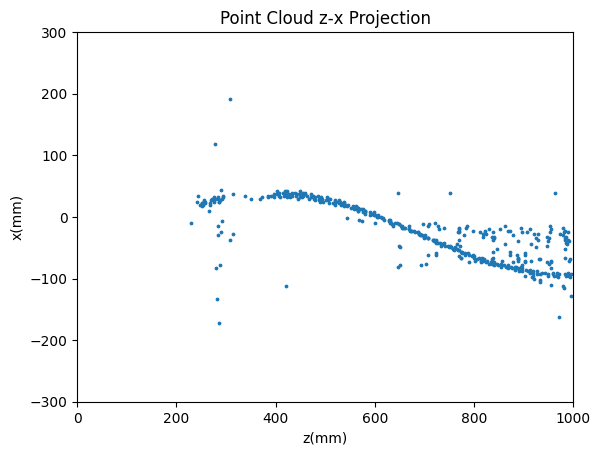

In [272]:
# Plot z-x projection
plt.scatter(cloud.cloud[:, 2], cloud.cloud[:, 0], s=3)
plt.title('Point Cloud z-x Projection')
plt.xlabel('z(mm)')
plt.xlim(0.0, 1000.0)
plt.ylabel('x(mm)')
plt.ylim(-300.0, 300.0)
plt.show()

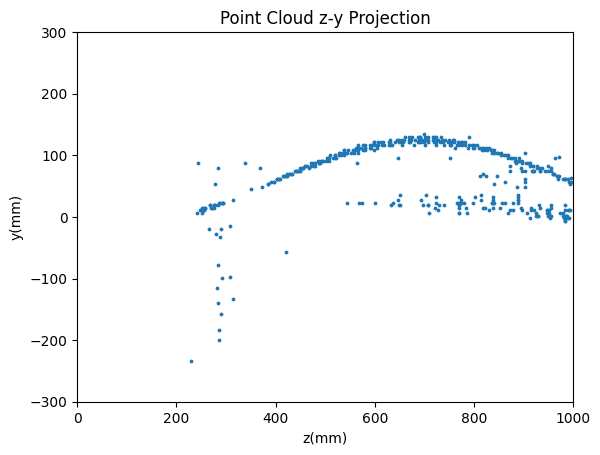

In [273]:
# Plot z-y projection
plt.scatter(cloud.cloud[:, 2], cloud.cloud[:, 1], s=3)
plt.title('Point Cloud z-y Projection')
plt.xlabel('z(mm)')
plt.xlim(0.0, 1000.0)
plt.ylabel('y(mm)')
plt.ylim(-300.0, 300.0)
plt.show()

You can even plot some interesting physics! Below is an example intended to try and plot a Bragg curve from the point cloud.

Text(0, 0.5, 'Integrated Charge (unitless)')

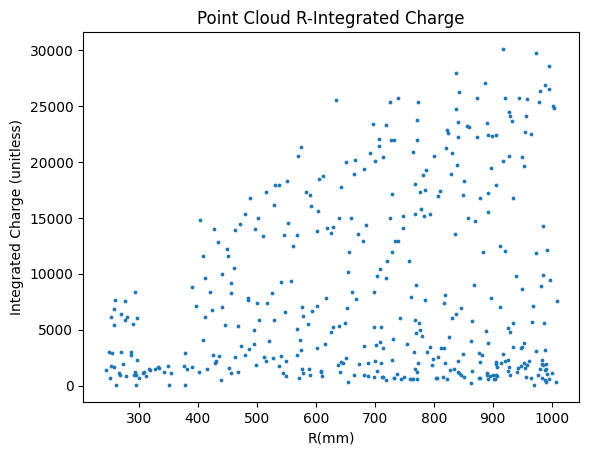

In [274]:
# Plot r-Charge projection
plt.scatter(np.linalg.norm(cloud.cloud[:, :3], axis=1), cloud.cloud[:, 4], s=3)
plt.title('Point Cloud R-Integrated Charge')
plt.xlabel('R(mm)')
plt.ylabel('Integrated Charge (unitless)')

### Conclusion

That is a basic analysis of the traces and the point cloud data! With well tuned parameters, you're now ready to run the phase 1 analysis. Follow the instructions in the README to do this. Once thats done, you can move on to the next stage, generating and identifying clusters within the point clouds.